In [1]:
#Loading up all libraries
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
# import cv2  
import datetime

Using TensorFlow backend.


In [2]:
# dimensions of our images.  
img_width, img_height = 224, 224  
   
top_model_weights_path = 'bottleneck_fc_model.h5'  
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
   
# number of epochs to train top model  
epochs = 100  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [4]:
#Loading vgc16 model
model = applications.VGG16(include_top=False, weights='imagenet')  


58892288/58889256 [==============================] - 6s 0us/step


In [11]:
start = datetime.datetime.now()
datagen = ImageDataGenerator(rescale=1. / 255)  
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = model.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 13412 images belonging to 6 classes.
Time:  1:24:39.863822


In [10]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = model.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2549 images belonging to 6 classes.
Time:  0:17:06.207839


## Start from here

In [3]:
start = datetime.datetime.now()
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 13412 images belonging to 6 classes.
Time:  0:00:01.324077


In [4]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2549 images belonging to 6 classes.


In [5]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=12,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 13412 samples, validate on 2549 samples
Epoch 1/12
13412/13412 [==============================] - 13s 974us/step - loss: 1.3703 - acc: 0.4640 - val_loss: 0.5314 - val_acc: 0.8341
Epoch 2/12
13412/13412 [==============================] - 12s 931us/step - loss: 0.5921 - acc: 0.8077 - val_loss: 0.3877 - val_acc: 0.8866
Epoch 3/12
13412/13412 [==============================] - 13s 938us/step - loss: 0.4471 - acc: 0.8564 - val_loss: 0.5305 - val_acc: 0.8533
Epoch 4/12
13412/13412 [==============================] - 13s 947us/step - loss: 0.3790 - acc: 0.8750 - val_loss: 0.3800 - val_acc: 0.9000
Epoch 5/12
13412/13412 [==============================] - 13s 958us/step - loss: 0.3484 - acc: 0.8914 - val_loss: 0.3627 - val_acc: 0.9051
Epoch 6/12
13412/13412 [==============================] - 13s 956us/step - loss: 0.3169 - acc: 0.9016 - val_loss: 0.5089 - val_acc: 0.8894
Epoch 7/12
13412/13412 [==============================] - 13s 968us/step - loss: 0.2850 - acc: 0.9111 - val_loss: 0.3

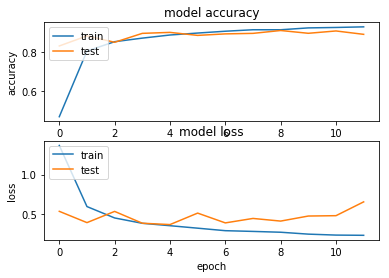

In [6]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [7]:
import matplotlib.image as mpimg

In [17]:
def read_image(file_path):
    image_path = file_path

    orig = mpimg.imread(image_path)  

    print("[INFO] loading and preprocessing image...")  
    image = load_img(image_path, target_size=(224, 224))  
    image = img_to_array(image)  

    # important! otherwise the predictions will be '0'  
    image = image / 255  

    image = np.expand_dims(image, axis=0)
    return image

In [28]:
path = 'data/test/squirells/OIP-VXViH2nd5GyiT51uR1Z_hQHaE6.jpeg'

In [29]:
image = read_image(path)

[INFO] loading and preprocessing image...


In [34]:
# build the VGG16 network  
model = applications.VGG16(include_top=False, weights='imagenet')  

# get the bottleneck prediction from the pre-trained VGG16 model  
bottleneck_prediction = model.predict(image)  

# build top model  
model = Sequential()  
model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

model.load_weights(top_model_weights_path)  

# use the bottleneck prediction on the top model to get the final classification  
class_predicted = model.predict_classes(bottleneck_prediction)

AttributeError: module 'keras.preprocessing.image' has no attribute 'ndim'

In [33]:
inID = class_predicted[0]  

class_dictionary = generator_top.class_indices  

inv_map = {v: k for k, v in class_dictionary.items()}  

label = inv_map[inID]  

# get the prediction label  
print("Image ID: {}, Label: {}".format(inID, label))  

# # display the predictions with the image  
# cv2.putText(orig, "Predicted: {}".format(label), (10, 30), cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)  

# cv2.imshow("Classification", orig)  
# cv2.waitKey(0)  
# cv2.destroyAllWindows()  

Image ID: 5, Label: squirels


<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
(224, 224, 3)


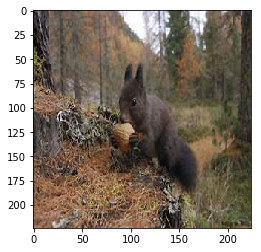

In [39]:
from keras.preprocessing import image

# img = np.random.rand(224,224,3)
# plt.imshow(img)
# plt.show()

img_path = path
img = image.load_img(img_path, target_size=(224, 224))
print(type(img))

x = image.img_to_array(img)
print(type(x))
print(x.shape)
plt.imshow(x/255.)


In [34]:
class_dictionary

{'butterflies': 0,
 'chickens': 1,
 'elephants': 2,
 'horses': 3,
 'spiders': 4,
 'squirels': 5}